### 1. Download the data

In [11]:
import os
import pandas as pd
import requests
import json
import sys

# create a session
session = requests.Session()

# replace 'username' and 'password' with your actual Transkribus username and password
# ideally this should be stored in another file; a config file or so that doesnt get pushed to GitHub
login_payload = {"user": "wouter.haverals@outlook.com", "pw": "pimco2-petsob-tedrEq"}

# log in
response = session.post('https://transkribus.eu/TrpServer/rest/auth/login', data=login_payload)

# successful login?
if response.status_code == 200:
    print('login successful')
else:
    print('failed to log in')
    sys.exit()

# after login, get a list of collections using the session
collections_response = session.get('https://transkribus.eu/TrpServer/rest/collections/list')

# parse the JSON response into a dict
collections_dict = json.loads(collections_response.text)

# find the collection id for the most beautiful collection of documents that ever existed -- 'Silent Voices'
for collection in collections_dict:
    if collection['colName'] == 'Silent Voices':
        silent_voices_id = collection['colId']
        print('Silent Voices collection id:', silent_voices_id)
        break
else:
    print("Collection 'Silent Voices' not found") # cry
    sys.exit()

def fetch_and_print_xml(session, collection_id, document_id, nr_of_transcripts=-1):
    xml_url = f'https://transkribus.eu/TrpServer/rest/collections/{collection_id}/{document_id}/fulldoc.xml'
    response = session.get(xml_url, params={'nrOfTranscripts': nr_of_transcripts})

    if response.status_code == 200:
        print(response.text)  # printing the XML content
    else:
        print(f"Failed to fetch XML for doc:{document_id}")


# get documents in the Silent Voices collection
documents_response = session.get(f'https://transkribus.eu/TrpServer/rest/collections/{silent_voices_id}/list')
documents_dict = json.loads(documents_response.text)

# an empty list to store the data
data = []

# list to store the summary data
summary_data = []

# loop through the documents
for document in documents_dict:
    if document['title'] in ['Brussel, KBR, 1805-1808',
                             'Brussel, KBR, 2485',
                             'Brussel, KBR, 2849-51',
                             #'Brussel, KBR, 2877-78',
                             #'Brussel, KBR, 2879-80',
                             #'Brussel, KBR, 2905-09',
                             #'Brussel, KBR, 2979',
                             #'Brussel, KBR, 3091',
                             #'Brussel, KBR, 3093-95',
                             #'Gent, UB, 1374', 
                             #'Gent, UB, 941',
                             #'Parijs, Bibliothèque Mazarine, 920',
                             #"Parijs, Bibliothèque de l'Arsenal, 8224",
                             #"Philadelphia, Lewis E 199", # Latin doc, not yet disclosed that this originated in Herne!!
                             #"Sint-Petersburg, BAN, O 256",
                             #"Wenen, ÖNB, 12.857",
                             #"Wenen, ÖNB, 12.905",
                             #"Wenen, ÖNB, 13.708",
                             #"Wenen, ÖNB, 65"]:
                            ]:
        

        doc_id = document['docId']
        
        # get full document data
        doc_response = session.get(f'https://transkribus.eu/TrpServer/rest/collections/{silent_voices_id}/{doc_id}/fulldoc')
        doc_dict = json.loads(doc_response.text)
        #print(doc_dict)
        # loop through the pages
        fetch_and_print_xml(session, silent_voices_id, doc_id)

        for page in doc_dict['pageList']['pages']:
            page_id = page['pageId']
            page_nr = page['pageNr']
            img_file_name = page['imgFileName']
            img_url = page['url']
            thumb_url = page['thumbUrl']
            ts_list = page['tsList']['transcripts']
            
            # find the **most recent** transcript by comparing timestamp 
            # this is messy, but it gets the job done i guess
            most_recent_ts = max(ts_list, key=lambda x: x['timestamp'])
            most_recent_url = most_recent_ts['url']  # here we actually get the url for the most recent transcript
            
            title = document['title']
            transkribuspage = page_nr
            original_filename = img_file_name
            status = most_recent_ts['status']
            doc_id = most_recent_ts['docId']
 
            # keepin' track of some stats -- nr of bounding boxes, lines, words
            nr_of_transcribed_regions = most_recent_ts.get('nrOfTranscribedRegions', 0)
            nr_of_lines = most_recent_ts.get('nrOfLines', 0)
            nr_of_words = most_recent_ts.get('nrOfWords', 0)
            
            # append all the data to list
            data.append([title, transkribuspage, original_filename, status, doc_id, nr_of_transcribed_regions, nr_of_lines, nr_of_words, most_recent_url, img_url, thumb_url])

        # collect the summary for this document
        summary = [
            document['title'], 
            doc_dict['md']['nrOfPages'], 
            doc_dict['md']['nrOfInProgress'], 
            doc_dict['md']['nrOfGT'], 
            doc_dict['md']['nrOfDone'], 
            doc_dict['md']['nrOfFinal'], 
            doc_dict['md']['nrOfRegions'], 
            doc_dict['md']['nrOfLines'], 
            doc_dict['md']['nrOfWords'],
            doc_dict['md']['nrOfTranscribedWords'],
            doc_dict['md']['nrOfCharsInLines']]
    
        summary_data.append(summary)

# summary containing stats on all docs
columns = ['codex_sig', 'NrOfPages', 'NrOfInProgress', 'NrOfGT', 'NrOfDone', 'NrOfFinal', 'NrOfRegions', 'NrOfLines', 'NrOfWords', 'NrOfTranscribedWords', 'NrOfCharsInLines']
df_summary = pd.DataFrame(summary_data, columns=columns)

# save summary to xlsx if you want
df_summary.to_excel("../data/silent_voices_summary.xlsx", index=False)
    
# create a df from 'data' for specific pages etc.
df = pd.DataFrame(data, columns=['codex_sig', 'transkribuspage', 'OriginalFilename', 'Status', 'DocId', 'NrOfTranscribedRegions', 'NrOfLines', 'NrOfWords', 'TranscriptURL', 'ImageURL', 'ThumbnailURL'])

# print the summary
df_summary

login successful
Silent Voices collection id: 149063
<?xml version="1.0" encoding="UTF-8" standalone="yes"?><trpDoc><md><nrOfRegions>206</nrOfRegions><nrOfTranscribedRegions>178</nrOfTranscribedRegions><nrOfWordsInRegions>20763</nrOfWordsInRegions><nrOfLines>3402</nrOfLines><nrOfTranscribedLines>3402</nrOfTranscribedLines><nrOfWordsInLines>27487</nrOfWordsInLines><nrOfWords>4479</nrOfWords><nrOfTranscribedWords>4479</nrOfTranscribedWords><nrOfCharsInLines>109238</nrOfCharsInLines><nrOfNew>0</nrOfNew><nrOfInProgress>20</nrOfInProgress><nrOfDone>0</nrOfDone><nrOfFinal>0</nrOfFinal><nrOfGT>122</nrOfGT><docId>1002641</docId><title>Brussel, KBR, 2485</title><uploadTimestamp>1652654242028</uploadTimestamp><scriptType>HANDWRITTEN</scriptType><uploader>wouter.haverals@outlook.com</uploader><uploaderId>77214</uploaderId><nrOfPages>142</nrOfPages><pageId>38379725</pageId><url>https://files.transkribus.eu/Get?fileType=view&amp;id=XFJWIUPRKGMHHHGMCGEYQDWY</url><thumbUrl>https://files.transkribus.e

codex_sig  NrOfPages  NrOfInProgress  NrOfGT  NrOfDone  \
0       Brussel, KBR, 2485        142              20     122         0   
1    Brussel, KBR, 2849-51        708             590     118         0   
2  Brussel, KBR, 1805-1808        148             114      21         1   

   NrOfFinal  NrOfRegions  NrOfLines  NrOfWords  NrOfTranscribedWords  \
0          0          206       3402       4479                  4479   
1          0         2484      19846     132185                132185   
2          0          406      12667      91464                 91464   

   NrOfCharsInLines  
0            109238  
1            550565  
2            361836

In [ ]:
import os
import requests

# create the pagexml dir
base_dir = "../data/pagexmls"
os.makedirs(base_dir, exist_ok=True)

# download files for each row in the df
for index, row in df.iterrows():
    title = row['codex_sig']
    url = row['TranscriptURL']
    folder_name = title #.replace(',', '').replace(' ', '_')
    folder_path = os.path.join(base_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    
    file_name = None

    # this is where i started hating the transkribus api
    # send a request to retrieve the headers 
    response = requests.head(url)
    if 'Content-Disposition' in response.headers:
        # extract the filename from the header
        header = response.headers['Content-Disposition']
        file_name = header.split('filename=')[1].strip('"')

    if not file_name:
        # safety measure -- if the filename couldn't be extracted from the header, use idx
        file_name = 'file_' + str(index) + '.xml'

    save_path = os.path.join(folder_path, file_name)

    # download file
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)
    print(f"Downloaded: {save_path}")
    
    # now let's do images
    base_dir_images = "../data/images"
    os.makedirs(base_dir_images, exist_ok=True)
    
    folder_path_images = os.path.join(base_dir_images, title)
    os.makedirs(folder_path_images, exist_ok=True)

    url_image = row['ImageURL']
    file_name = row['OriginalFilename'] if pd.notnull(row['OriginalFilename']) else None

    if not file_name:
        response = requests.head(url_image)
        if 'Content-Disposition' in response.headers:
            header = response.headers['Content-Disposition']
            file_name = header.split('filename=')[1].strip('"')

        if not file_name:
            file_name = 'file_' + str(index) + '.jpg' # assuming images are in jpg format

    save_path_images = os.path.join(folder_path_images, file_name)
    response = requests.get(url_image)
    with open(save_path_images, 'wb') as file:
        file.write(response.content)
    print(f"Downloaded: {save_path_images}")

Downloaded: ../data/pagexmls/Brussel, KBR, 2485/0_front_r.xml
Downloaded: ../data/images/Brussel, KBR, 2485/0_front_r.jpeg
Downloaded: ../data/pagexmls/Brussel, KBR, 2485/0_front_v.xml
Downloaded: ../data/images/Brussel, KBR, 2485/0_front_v.jpeg
Downloaded: ../data/pagexmls/Brussel, KBR, 2485/1r.xml
Downloaded: ../data/images/Brussel, KBR, 2485/1r.jpeg
Downloaded: ../data/pagexmls/Brussel, KBR, 2485/1v.xml
Downloaded: ../data/images/Brussel, KBR, 2485/1v.jpeg
Downloaded: ../data/pagexmls/Brussel, KBR, 2485/2r.xml
Downloaded: ../data/images/Brussel, KBR, 2485/2r.jpeg
Downloaded: ../data/pagexmls/Brussel, KBR, 2485/2v.xml
Downloaded: ../data/images/Brussel, KBR, 2485/2v.jpeg
Downloaded: ../data/pagexmls/Brussel, KBR, 2485/3r.xml
Downloaded: ../data/images/Brussel, KBR, 2485/3r.jpeg
Downloaded: ../data/pagexmls/Brussel, KBR, 2485/3v.xml
Downloaded: ../data/images/Brussel, KBR, 2485/3v.jpeg
Downloaded: ../data/pagexmls/Brussel, KBR, 2485/4r.xml
Downloaded: ../data/images/Brussel, KBR, 2485

### 2. Extract metadata from PAGE XML files

The code block below extracts metadata from PAGE XML files and stores the data in a pandas DataFrame. The extracted metadata includes the **manuscript signature**, the **Transrkibus page number**, **image filename**, **image width** and **height**, **text region type**, **region coordinates**, **full text**, and **reading order**. 

Apart from this metadata which can be extracted from the PAGE XML directly, we also calculate the **fraction** that a region takes up in an image. To this end, we first calculate the area of the region (using the Shoelace formula) and the area of the full image. Next, we divide the area of the text region by the area of the full image to get the fraction.

The full DataFrame is then exported to an Excel file named `manuscript_data.xlsx`

In [99]:
import os
from tqdm import tqdm
import pandas as pd
from lxml import etree
import re

# function to calculate area of a polygon given its coordinates
def polygon_area(coords):
    n = len(coords)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += coords[i][0] * coords[j][1]
        area -= coords[j][0] * coords[i][1]
    return abs(area / 2.0)

In [100]:
def extract_metadata(page_files):
    ns = {'pc': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15'}
    metadata = pd.DataFrame(columns=['codex_sig', 'transkribuspage', 'image_filename', 'page_xml_filename', 'image_width', 'image_height', 'region_type', 'coordinates', 'fraction', 'text', 'reading_order', 'status'])
    for page_file in tqdm(page_files):
        page_filename = os.path.basename(page_file)
        with open(page_file, 'rb') as f:
            tree = etree.parse(f)

            # Adjusted to go two levels up for manuscript signature
            manuscript = os.path.basename(os.path.dirname(os.path.dirname(page_file))).replace('_', ', ')

            image_filename = tree.xpath("//pc:Page/@imageFilename", namespaces=ns)
            image_filename = image_filename[0] if image_filename else None

            image_width = tree.xpath("//pc:Page/@imageWidth", namespaces=ns)
            image_width = int(image_width[0]) if image_width else None

            image_height = tree.xpath("//pc:Page/@imageHeight", namespaces=ns)
            image_height = int(image_height[0]) if image_height else None

            page_nr = tree.xpath("//pc:TranskribusMetadata/@pageNr", namespaces=ns)
            page_nr = int(page_nr[0]) if page_nr else None

            status = tree.xpath("//pc:TranskribusMetadata/@status", namespaces=ns)
            status = status[0] if status else None

            for text_region in tree.xpath('//pc:TextRegion', namespaces=ns):
                region_type = text_region.get('type')
                custom = text_region.get('custom')
                reading_order = custom.split("index:")[1].split(";")[0].strip() if custom else None

                for coords in text_region.xpath('./pc:Coords[1]/@points', namespaces=ns):
                    text_region_coords = coords
                    region_coords = text_region_coords.split()
                    #print(region_coords)
                    region_coords = [(int(coord.split(',')[0]), int(coord.split(',')[1])) for coord in region_coords]
                    polygon_area_size = polygon_area(region_coords)
                    image_area = image_width * image_height if image_width and image_height else None
                    fraction = polygon_area_size / image_area if image_area else None
                    formatted_fraction = "{:.2f}".format(fraction) if fraction else None

                full_text = []
                for text_line in text_region.xpath('.//pc:TextLine', namespaces=ns):
                    unicode_list = text_line.xpath('./pc:TextEquiv[last()]/pc:Unicode', namespaces=ns)
                    final_unicode = unicode_list[0].text if len(unicode_list) > 0 else ' '
                    full_text.append(final_unicode)

                final_text = '\n'.join(filter(None, full_text))
                
                row = {
                    'codex_sig': [manuscript],
                    'transkribuspage': [page_nr],
                    'image_filename': [image_filename],
                    'page_xml_filename': [page_filename],
                    'image_width': [image_width],
                    'image_height': [image_height],
                    'region_type': [region_type],
                    'coordinates': [text_region_coords],
                    'fraction': [formatted_fraction],
                    'text': [final_text],
                    'reading_order' : [reading_order],
                    'status': [status]}

                metadata = pd.concat([metadata, pd.DataFrame(row)], ignore_index=True)
    return metadata

page_files = []
for root, dirs, files in os.walk('../data/export'):  # Updated path
    if os.path.basename(root) == 'page':
        for file in files:
            if file.endswith('.xml'):
                page_files.append(os.path.join(root, file))

df = extract_metadata(page_files)
df = df.sort_values(by=['codex_sig', 'transkribuspage'], ascending=[True, True])
df = df.reset_index(drop=True)
df.to_excel('../data/manuscript_data_new.xlsx', index=False)


100%|██████████| 6328/6328 [01:01<00:00, 103.46it/s]


In [101]:
df # df from pagexmls

codex_sig transkribuspage            image_filename  \
0      Brussel,, KBR,, 1805-1808               7  0007_KBR_1805-08_1r.tiff   
1      Brussel,, KBR,, 1805-1808               7  0007_KBR_1805-08_1r.tiff   
2      Brussel,, KBR,, 1805-1808               8  0008_KBR_1805-08_1v.tiff   
3      Brussel,, KBR,, 1805-1808               8  0008_KBR_1805-08_1v.tiff   
4      Brussel,, KBR,, 1805-1808               9  0009_KBR_1805-08_2r.tiff   
...                          ...             ...                       ...   
15917          Wenen,, ÖNB,, 65             193              00000193.jpg   
15918          Wenen,, ÖNB,, 65             193              00000193.jpg   
15919          Wenen,, ÖNB,, 65             194              00000194.jpg   
15920          Wenen,, ÖNB,, 65             194              00000194.jpg   
15921          Wenen,, ÖNB,, 65             194              00000194.jpg   

             page_xml_filename image_width image_height region_type  \
0      0007_KBR_1805-08_1r.xml        5186         7123      header   
1      0007_KBR_1805-08_1r.xml        5186         7123   paragraph   
2      0008_KBR_1805-08_1v.xml        5186         7123   paragraph   
3      0008_KBR_1805-08_1v.xml        5186         7123  marginalia   
4      0009_KBR_1805-08_2r.xml        5186         7123   paragraph   
...                        ...         ...          ...         ...   
15917             00000193.xml        1944         2598   paragraph   
15918             00000193.xml        1944         2598  marginalia   
15919             00000194.xml        1932         2625   paragraph   
15920             00000194.xml        1932         2625   paragraph   
15921             00000194.xml        1932         2625  marginalia   

                                             coordinates fraction  \
0                    1405,478 3598,478 3598,721 1405,721     0.01   
1                  1359,751 3792,751 3792,2645 1359,2645     0.12   
2                  1736,658 3985,658 3985,1643 1736,1643     0.06   
3                2414,1705 4016,1705 4016,1851 2414,1851     0.01   
4      859,5840 847,5678 835,5462 781,4838 751,4480 7...     0.23   
...                                                  ...      ...   
15917                952,250 1747,250 1747,2108 952,2108     0.29   
15918            1757,1097 1757,1185 1825,1187 1825,1099     0.00   
15919                281,276 281,2114 1029,2114 1029,276     0.27   
15920                1105,276 1106,578 1866,578 1865,276     0.05   
15921                1101,585 1797,585 1797,658 1101,658     0.01   

                                                    text reading_order  \
0              Een voorredene op sinte gregoriꝰ dyalogus             0   
1      DE zeere wise e saleghe gregoris paeus\nvan d...             1   
2      wiste dat si hare te xpūs gheloeue ghege-\nuen...             0   
3                      ⸫ Nēmeer en vant ics jnt latijn .             1   
4      Hier beghint een voʼredene\nop .Sʼ. gᵉgorius d...             0   
...                                                  ...           ...   
15917  so verre kinne vandē volcomenen\nloue der heil...             2   
15918                                                noᵃ             3   
15919  glorificerē selen inder eewicheit .\nDe die pe...             0   
15920  Dit boec es in dietsche vten lati-\nne ghetogh...             1   
15921                       Dies biedic s Oddʼ si anet v             2   

            status  
0               GT  
1               GT  
2               GT  
3               GT  
4               GT  
...            ...  
15917  IN_PROGRESS  
15918  IN_PROGRESS  
15919  IN_PROGRESS  
15920  IN_PROGRESS  
15921  IN_PROGRESS  

[15922 rows x 12 columns]

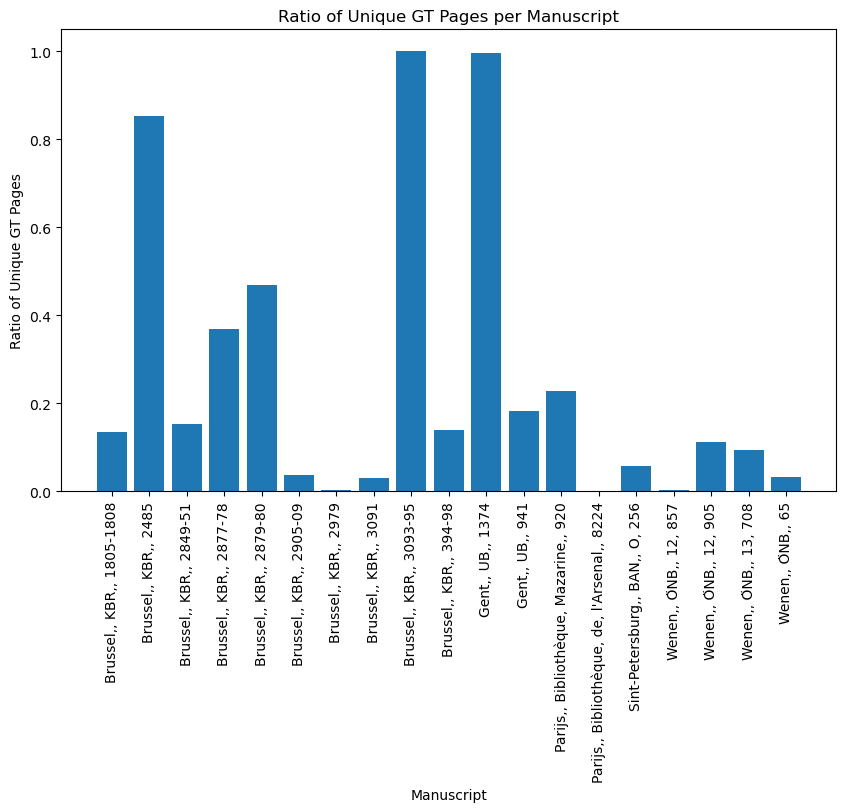

In [102]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame

# Filter to include only GT status rows
gt_df = df[df['status'] == 'GT']

# Group by codex_sig and count unique transkribuspage (GT pages)
unique_gt_pages = gt_df.groupby('codex_sig')['transkribuspage'].nunique()

# Calculate the total unique pages per manuscript (regardless of status)
total_pages_per_manuscript = df.groupby('codex_sig')['transkribuspage'].nunique()

# Calculate the ratio of unique GT pages per manuscript
gt_ratio = unique_gt_pages / total_pages_per_manuscript

# Prepare data for plotting
manuscripts, ratios = zip(*gt_ratio.items())

# Create grid plot
plt.figure(figsize=(10, 6))
plt.bar(manuscripts, ratios)
plt.xlabel('Manuscript')
plt.ylabel('Ratio of Unique GT Pages')
plt.title('Ratio of Unique GT Pages per Manuscript')
plt.xticks(rotation=90)
plt.show()


### 3. Merge with additional information stored in another spreadsheet

In [103]:
## OPTION 1: access sheet through Google Drive API
#!pip install gspread

import gspread
sa = gspread.service_account(filename="../silentvoices-42d7a9a8450e.json")
sheet = sa.open_by_url("https://docs.google.com/spreadsheets/d/1EJQtcZ63ZA6Po3HAhBchMkrcwTQMhFp1W1XjkW1wwuc")

# get list of all worksheets
all_worksheets = sheet.worksheets()

# initialize an empty dictionary to store the dataframes
dfs = {}

# loop through each worksheet
for ws in all_worksheets:
    print(ws)
    # get all values of the worksheet
    values = ws.get_all_values()
    # only keep the first 15 columns (A to O in excel)
    values = [row[:15] for row in values]
    # convert to a df, assuming first row is the header
    df_temp = pd.DataFrame(values[1:], columns=values[0])
    
    # store df
    dfs[ws.title] = df_temp

# remove the overview sheet
if 'OVERVIEW' in dfs:
    del dfs['OVERVIEW']

# concat the dfs
add_df = pd.concat(dfs.values(), ignore_index=True)

<Worksheet 'OVERVIEW' id:1053394346>
<Worksheet 'KBR 394-98' id:2016912023>
<Worksheet 'KBR 1805-08' id:762308753>
<Worksheet 'KBR 2485' id:0>
<Worksheet 'KBR 2849-51' id:956390397>
<Worksheet 'KBR 2877-78' id:387871519>
<Worksheet 'KBR 2879-80' id:352703624>
<Worksheet 'KBR 2905-09' id:460677957>
<Worksheet 'KBR 2979' id:1622097260>
<Worksheet 'KBR 3091' id:1367553580>
<Worksheet 'KBR 3093-95' id:2032175414>
<Worksheet 'Ghent UB 941' id:1567686002>
<Worksheet 'Ghent UB 1374' id:773429885>
<Worksheet 'BA 8224' id:841632581>
<Worksheet 'MA 920' id:1158373373>
<Worksheet 'BAN O256' id:1901642224>
<Worksheet 'ÖNB 13708' id:19886449>
<Worksheet 'ÖNB 65' id:1868536383>
<Worksheet 'ÖNB 12905' id:2075030953>
<Worksheet 'ÖNB 12857' id:571355786>
<Worksheet 'Lewis E 199' id:1609201371>


In [104]:
import unicodedata

# Dictionary for city name translations
city_translations = {
    'Brussel': 'Brussels',
    'Gent': 'Ghent',
    'Wenen': 'Vienna',
    'Parijs': 'Paris',
    'Sint-Petersburg': 'Saint Petersburg'
}

def standardize_codex_sig(value):
    # Normalize the value and remove extra spaces/commas
    value = unicodedata.normalize('NFC', ' '.join(value.replace(',', '').split()))

    # Translate city names
    for city in city_translations:
        if city in value:
            value = value.replace(city, city_translations[city])

    # Special handling for "Wenen" (Vienna) manuscripts
    if "Vienna ÖNB" in value:
        parts = value.split("ÖNB")
        if len(parts) == 2:
            # Handle the manuscript number part
            number_part = parts[1].strip()
            # Replace spaces with a period only if there's more than one number
            if " " in number_part:
                number_part = number_part.replace(" ", ".", 1)
            value = "Vienna ÖNB " + number_part

    return value

# Apply the function to both DataFrames
df['codex_sig'] = df['codex_sig'].apply(standardize_codex_sig)
add_df['codex_sig'] = add_df['codex_sig'].apply(standardize_codex_sig)


def normalize_unicode(value):
    return unicodedata.normalize('NFC', value)

# Apply normalization to the 'page_xml_filename' column in both DataFrames
df['page_xml_filename'] = df['page_xml_filename'].apply(normalize_unicode)
add_df['page_xml_filename'] = add_df['page_xml_filename'].apply(normalize_unicode)

# Now you can proceed with the merging process
df_merged = pd.merge(df, add_df, on=['codex_sig', 'page_xml_filename'], how='left')

# now check the unique values
print(df['codex_sig'].unique())
print(add_df['codex_sig'].unique())


['Brussels KBR 1805-1808' 'Brussels KBR 2485' 'Brussels KBR 2849-51'
 'Brussels KBR 2877-78' 'Brussels KBR 2879-80' 'Brussels KBR 2905-09'
 'Brussels KBR 2979' 'Brussels KBR 3091' 'Brussels KBR 3093-95'
 'Brussels KBR 394-98' 'Ghent UB 1374' 'Ghent UB 941'
 'Paris Bibliothèque Mazarine 920' "Paris Bibliothèque de l'Arsenal 8224"
 'Saint Petersburg BAN O 256' 'Vienna ÖNB 12.857' 'Vienna ÖNB 12.905'
 'Vienna ÖNB 13.708' 'Vienna ÖNB 65']
['Brussels KBR 394-98' 'Brussels KBR 1805-1808' 'Brussels KBR 2485'
 'Brussels KBR 2849-51' 'Brussels KBR 2877-78' 'Brussels KBR 2879-80'
 'Brussels KBR 2905-09' 'Brussels KBR 2979' 'Brussels KBR 3091'
 'Brussels KBR 3093-95' 'Ghent UB 941' 'Ghent UB 1374'
 "Paris Bibliothèque de l'Arsenal 8224" 'Paris Bibliothèque Mazarine 920'
 'Saint Petersburg BAN O 256' '' 'Vienna ÖNB 13.708' 'Vienna ÖNB 65'
 'Vienna ÖNB 12.905' 'Vienna ÖNB 12.857' 'Philadelphia Lewis E 199']


In [105]:
# merge the dfs
df_merged = pd.merge(df, add_df, on=['codex_sig', 'page_xml_filename'], how='left')

# save the merged dfs
df_merged.to_excel('../data/manuscript_data_metadata.xlsx')

In [106]:
df_merged

codex_sig transkribuspage_x            image_filename  \
0      Brussels KBR 1805-1808                 7  0007_KBR_1805-08_1r.tiff   
1      Brussels KBR 1805-1808                 7  0007_KBR_1805-08_1r.tiff   
2      Brussels KBR 1805-1808                 8  0008_KBR_1805-08_1v.tiff   
3      Brussels KBR 1805-1808                 8  0008_KBR_1805-08_1v.tiff   
4      Brussels KBR 1805-1808                 9  0009_KBR_1805-08_2r.tiff   
...                       ...               ...                       ...   
15917           Vienna ÖNB 65               193              00000193.jpg   
15918           Vienna ÖNB 65               193              00000193.jpg   
15919           Vienna ÖNB 65               194              00000194.jpg   
15920           Vienna ÖNB 65               194              00000194.jpg   
15921           Vienna ÖNB 65               194              00000194.jpg   

             page_xml_filename image_width image_height region_type  \
0      0007_KBR_1805-08_1r.xml        5186         7123      header   
1      0007_KBR_1805-08_1r.xml        5186         7123   paragraph   
2      0008_KBR_1805-08_1v.xml        5186         7123   paragraph   
3      0008_KBR_1805-08_1v.xml        5186         7123  marginalia   
4      0009_KBR_1805-08_2r.xml        5186         7123   paragraph   
...                        ...         ...          ...         ...   
15917             00000193.xml        1944         2598   paragraph   
15918             00000193.xml        1944         2598  marginalia   
15919             00000194.xml        1932         2625   paragraph   
15920             00000194.xml        1932         2625   paragraph   
15921             00000194.xml        1932         2625  marginalia   

                                             coordinates fraction  \
0                    1405,478 3598,478 3598,721 1405,721     0.01   
1                  1359,751 3792,751 3792,2645 1359,2645     0.12   
2                  1736,658 3985,658 3985,1643 1736,1643     0.06   
3                2414,1705 4016,1705 4016,1851 2414,1851     0.01   
4      859,5840 847,5678 835,5462 781,4838 751,4480 7...     0.23   
...                                                  ...      ...   
15917                952,250 1747,250 1747,2108 952,2108     0.29   
15918            1757,1097 1757,1185 1825,1187 1825,1099     0.00   
15919                281,276 281,2114 1029,2114 1029,276     0.27   
15920                1105,276 1106,578 1866,578 1865,276     0.05   
15921                1101,585 1797,585 1797,658 1101,658     0.01   

                                                    text  ...     layout  \
0              Een voorredene op sinte gregoriꝰ dyalogus  ...  corrected   
1      DE zeere wise e saleghe gregoris paeus\nvan d...  ...  corrected   
2      wiste dat si hare te xpūs gheloeue ghege-\nuen...  ...  corrected   
3                      ⸫ Nēmeer en vant ics jnt latijn .  ...  corrected   
4      Hier beghint een voʼredene\nop .Sʼ. gᵉgorius d...  ...  corrected   
...                                                  ...  ...        ...   
15917  so verre kinne vandē volcomenen\nloue der heil...  ...  corrected   
15918                                                noᵃ  ...  corrected   
15919  glorificerē selen inder eewicheit .\nDe die pe...  ...  corrected   
15920  Dit boec es in dietsche vten lati-\nne ghetogh...  ...  corrected   
15921                       Dies biedic s Oddʼ si anet v  ...  corrected   

               content     language scribe production unit  \
0              proloog  middledutch      a               I   
1              proloog  middledutch      a               I   
2              proloog  middledutch      a               I   
3              proloog  middledutch      a               I   
4      dialogenGreg1_3  middledutch      α               I   
...                ...          ...    ...             ...   
15917        horlogium  middledutch      γ              IV   
1591

In [ ]:
# OPTION 2: donwnload the codex_info file from GDrive and load the data from that file

# we're going to merge the spreadsheet with other information, relating to the corpus (such as: scribe, production unit, etc.)
fn = '../data/codex_info.xlsx'
sheets = pd.read_excel(fn, sheet_name=None)
del sheets['OVERVIEW'] # delete the overview-sheet

In [124]:
sheets.keys() # names of the sheets (i.e. manuscript sigla)

dict_keys(['KBR 394-98', 'KBR 1805-08', 'KBR 2485', 'KBR 2849-51', 'KBR 2877-78', 'KBR 2879-80', 'KBR 2905-09', 'KBR 2979', 'KBR 3091', 'KBR 3093-95', 'Ghent UB 941', 'Ghent UB 1374', 'BA 8224', 'MA 920', 'BAN O256', 'ÖNB 13708', 'ÖNB 65', 'ÖNB 12905', 'ÖNB 12857', 'Lewis E 199'])

In [125]:
add_df = pd.concat(sheets.values())
add_df.reset_index(inplace=True, drop=True)
columns_to_drop = ['Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']
for column in columns_to_drop:
    if column in add_df.columns:
        add_df.drop(column, axis=1, inplace=True)

In [126]:
add_df.head()

codex_sig  transkribuspage                    filename folium  \
0  Brussel, KBR, 394-98                1  0001_KBR_394-98_cover.tiff  cover   
1  Brussel, KBR, 394-98                2  0002_KBR_394-98_blank.tiff  blank   
2  Brussel, KBR, 394-98                3  0003_KBR_394-98_blank.tiff  blank   
3  Brussel, KBR, 394-98                4  0004_KBR_394-98_blank.tiff  blank   
4  Brussel, KBR, 394-98                5     0005_KBR_394-98_1r.tiff     1r   

      layout   content language scribe production unit local Herne product  \
0  corrected      none     none   none            none                  no   
1  corrected      none     none   none            none                  no   
2  corrected      none     none   none            none                none   
3  corrected      none     none   none            none                none   
4  corrected  calendar     none      A               I                 yes   

        date translator transcription HTR-model used  CER?  
0  1450-1500        NaN          none            NaN   NaN  
1  1450-1500        NaN          none            NaN   NaN  
2       none        NaN          none            NaN   NaN  
3       none        NaN          none            NaN   NaN  
4  1373-1383        NaN          none            NaN   NaN

In [127]:
# we merge the two dataframes
df_merged = pd.merge(df, add_df, on=['codex_sig', 'transkribuspage'], how='left')

# save merged dataframe
df_merged.to_excel('../data/manuscript_data_metadata.xlsx')

In [128]:
df_merged

codex_sig transkribuspage            image_filename  \
0      Brussel, KBR, 1805-1808               7  0007_KBR_1805-08_1r.tiff   
1      Brussel, KBR, 1805-1808               7  0007_KBR_1805-08_1r.tiff   
2      Brussel, KBR, 1805-1808               8             47180129.tiff   
3      Brussel, KBR, 1805-1808               8             47180129.tiff   
4      Brussel, KBR, 1805-1808               9  0009_KBR_1805-08_2r.tiff   
...                        ...             ...                       ...   
13758          Wenen, ÖNB, 65             193              50510902.jpg   
13759          Wenen, ÖNB, 65             193              50510902.jpg   
13760          Wenen, ÖNB, 65             194              50510904.jpg   
13761          Wenen, ÖNB, 65             194              50510904.jpg   
13762          Wenen, ÖNB, 65             194              50510904.jpg   

             page_xml_filename image_width image_height region_type  \
0      0007_KBR_1805-08_1r.xml        5186         7123      header   
1      0007_KBR_1805-08_1r.xml        5186         7123   paragraph   
2      0008_KBR_1805-08_1v.xml        5186         7123   paragraph   
3      0008_KBR_1805-08_1v.xml        5186         7123  marginalia   
4      0009_KBR_1805-08_2r.xml        5186         7123   paragraph   
...                        ...         ...          ...         ...   
13758             00000193.xml        1944         2598   paragraph   
13759             00000193.xml        1944         2598  marginalia   
13760             00000194.xml        1932         2625   paragraph   
13761             00000194.xml        1932         2625   paragraph   
13762             00000194.xml        1932         2625  marginalia   

                                             coordinates fraction  \
0                    1405,478 3598,478 3598,721 1405,721     0.01   
1                  1359,751 3792,751 3792,2645 1359,2645     0.12   
2                  1736,658 3985,658 3985,1643 1736,1643     0.06   
3                2414,1705 4016,1705 4016,1851 2414,1851     0.01   
4      859,5840 847,5678 835,5462 781,4838 751,4480 7...     0.23   
...                                                  ...      ...   
13758                952,250 1747,250 1747,2108 952,2108     0.29   
13759            1757,1097 1757,1185 1825,1187 1825,1099     0.00   
13760                281,276 281,2114 1029,2114 1029,276     0.27   
13761                1105,276 1106,578 1866,578 1865,276     0.05   
13762                1101,585 1797,585 1797,658 1101,658     0.01   

                                                    text  ...  \
0              Een voorredene op sinte gregoriꝰ dyalogus  ...   
1      DE zeere wise e saleghe gregoris paeus\nvan d...  ...   
2      wiste dat si hare te xpūs gheloeue ghege-\nuen...  ...   
3                      ⸫ Nēmeer en vant ics jnt latijn .  ...   
4      Hier beghint een voʼredene\nop .Sʼ. gᵉgorius d...  ...   
...                                                  ...  ...   
13758  so verre kinne vandē volcomenen\nloue der heil...  ...   
13759                                                noᵃ  ...   
13760  glorificerē selen inder eewicheit .\nDe die pe...  ...   
13761  Dit boec es in dietsche vten lati-\nne ghetogh...  ...   
13762                       Dies biedic s Oddʼ si anet v  ...   

               content     language scribe production unit  \
0              proloog  middledutch      a               I   
1              proloog  middledutch      a               I   
2              proloog  middledutch      a               I   
3              proloog  middledutch      a               I   
4      dialogenGreg1_3  middledutch      α               I   
...                ...          ...    ...             ...   
13758              NaN          NaN    NaN             NaN   
13759              NaN          NaN    NaN             NaN   
13760              NaN          NaN    NaN             NaN   
13761              NaN   

### 3. Add HTR-data to the dataframe

In [107]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# load the excel file
df = pd.read_excel('../data/manuscript_data_rich.xlsx')

# filter df by language
df = df[df['language'] == 'middledutch']

# fill NaN values in the 'text' column with an empty string
df['text'] = df['text'].fillna('')

# initialize CountVectorizer for text tokenization
vectorizer = CountVectorizer(tokenizer=lambda text: text.split())

results = []
# group by codex_sig and iterate
for codex, group in df.groupby('codex_sig'):
    result = {}
    result['Witness'] = codex

    # split production units on '-' and count unique units
    unique_production_units = set()
    for unit in group['production unit'].dropna():
        unique_production_units.update(unit.split('-'))
    result['Production units containing Middle Dutch text'] = len(unique_production_units)

    # count unique folium values
    result['Folia (recto and verso)'] = group['folium'].nunique()

    # tokenize text column and count total and unique tokens
    tokens = vectorizer.fit_transform(group['text']).toarray()
    total_tokens = tokens.sum()
    unique_tokens = len(vectorizer.get_feature_names_out())

    result['Number of tokens'] = total_tokens
    result['Type-token ratio'] = total_tokens / unique_tokens if unique_tokens != 0 else 0
    
    # count unique characters
    unique_chars = set(''.join(group['text']))
    result['Number of unique characters'] = len(unique_chars)

    # split scribe units on '-' and count unique units, disregard 'none', 'unknown' and empty cells
    unique_scribes = set()
    for scribe in group['scribe'].dropna():
        if scribe.lower() not in ['none', 'unknown']:
            unique_scribes.update(scribe.split('-'))
    result['Number of unique scribes'] = len(unique_scribes)

    results.append(result)

# df
result_df = pd.DataFrame(results)

/Users/wh4213/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [108]:
result_df

Witness  \
0                   Brussel, KBR, 1805-1808   
1                        Brussel, KBR, 2485   
2                     Brussel, KBR, 2849-51   
3                     Brussel, KBR, 2877-78   
4                     Brussel, KBR, 2879-80   
5                     Brussel, KBR, 2905-09   
6                        Brussel, KBR, 2979   
7                        Brussel, KBR, 3091   
8                     Brussel, KBR, 3093-95   
9                            Gent, UB, 1374   
10                            Gent, UB, 941   
11       Parijs, Bibliothèque Mazarine, 920   
12  Parijs, Bibliothèque de l'Arsenal, 8224   
13              Sint-Petersburg, BAN, O 256   
14                       Wenen, ÖNB, 12.857   
15                       Wenen, ÖNB, 12.905   
16                       Wenen, ÖNB, 13.708   
17                           Wenen, ÖNB, 65   

    Production units containing Middle Dutch text  Folia (recto and verso)  \
0                                               3                      132   
1                                               2                      135   
2                                               7                      693   
3                                               2                      330   
4                                               3                      202   
5                                              10                      384   
6                                               2                       49   
7                                               1                      452   
8                                               2                      374   
9                                               5                      264   
10                                              2                       91   
11                                              8                      285   
12                                              2                       22   
13                                              5                      172   
14                                              4                      479   
15                                              1                      400   
16                                             11                      490   
17                                              4                      186   

    Number of tokens  Type-token ratio  Number of unique characters  \
0              95503          6.727932                          107   
1              27442          5.985169                           87   
2             154399          8.096010                          122   
3              90181          7.614709                           84   
4              82113          7.431713                           93   
5              46954          5.734489                           94   
6                216          1.611940                           45   
7              75179          7.692520                           96   
8              40444          5.194452                          101   
9              77717          7.281645                          116   
10             29563          5.508291                           75   
11             54893          5.339267                           97   
12              1020          1.658537                           61   
13             43375          4.956576                           95   
14             84063          7.732064                          104   
15             73196          6.130318                           96   
16            281228          8.300708                          118   
17             74160          6.340087                           92   

    Number of unique scribes  
0                          4  
1                          1  
2                          1  
3                          1  
4                          3  
5                          2  
6                          3  
7                          2  
8                          2  

In [294]:
# save
result_df.to_excel("manuscript_analysis.xlsx", index=False)